In [4]:
import os

from tree_sitter import Language, Parser

TREE_SITTER_LIB_PREFIX = "./lib"

languages = ["java"]
language_dirs = []

for lang in languages:
    clone_dir = os.path.join(TREE_SITTER_LIB_PREFIX, f"tree-sitter-{lang}")
    language_dirs.append(clone_dir)

lib_file = os.path.join(TREE_SITTER_LIB_PREFIX, "build/languages.so")
Language.build_library(
    # Store the library in the `build` directory
    lib_file,
    # Include one or more languages
    [
        os.path.join(TREE_SITTER_LIB_PREFIX, f"tree-sitter-{lang}"),
    ],
)

LANGUAGE = Language(lib_file, languages[0])
parser = Parser()
parser.set_language(LANGUAGE)


def parse_file(filename):
    with open(filename, "rb") as f:
        tree = parser.parse(f.read())
    return tree

def print_node(node):
    text = node.text.decode()
    if "\n" in text:
        text = text.splitlines(keepends=False)[0] + "..."
    print(node, text)

def print_tree(root):
    q = [(root, 0)]
    while len(q) > 0:
        n, level = q.pop(-1)
        print("  " * level, end="")
        print_node(n)
        q.extend([(m, level+1) for m in reversed(n.children)])

tree = parser.parse("""public class Foo {
    public void main() {
        System.out.println("Hello, world!");
    }
}""".encode())
print_tree(tree.root_node)

<Node type=program, start_point=(0, 0), end_point=(4, 1)> public class Foo {...
  <Node type=class_declaration, start_point=(0, 0), end_point=(4, 1)> public class Foo {...
    <Node type=modifiers, start_point=(0, 0), end_point=(0, 6)> public
      <Node type="public", start_point=(0, 0), end_point=(0, 6)> public
    <Node type="class", start_point=(0, 7), end_point=(0, 12)> class
    <Node type=identifier, start_point=(0, 13), end_point=(0, 16)> Foo
    <Node type=class_body, start_point=(0, 17), end_point=(4, 1)> {...
      <Node type="{", start_point=(0, 17), end_point=(0, 18)> {
      <Node type=method_declaration, start_point=(1, 4), end_point=(3, 5)> public void main() {...
        <Node type=modifiers, start_point=(1, 4), end_point=(1, 10)> public
          <Node type="public", start_point=(1, 4), end_point=(1, 10)> public
        <Node type=void_type, start_point=(1, 11), end_point=(1, 15)> void
        <Node type=identifier, start_point=(1, 16), end_point=(1, 20)> main
       

In [5]:
tree = parser.parse("""public class FooWithNative {
    private static native boolean parse(String bytes);
}""".encode())
print_tree(tree.root_node)

<Node type=program, start_point=(0, 0), end_point=(2, 1)> public class FooWithNative {...
  <Node type=class_declaration, start_point=(0, 0), end_point=(2, 1)> public class FooWithNative {...
    <Node type=modifiers, start_point=(0, 0), end_point=(0, 6)> public
      <Node type="public", start_point=(0, 0), end_point=(0, 6)> public
    <Node type="class", start_point=(0, 7), end_point=(0, 12)> class
    <Node type=identifier, start_point=(0, 13), end_point=(0, 26)> FooWithNative
    <Node type=class_body, start_point=(0, 27), end_point=(2, 1)> {...
      <Node type="{", start_point=(0, 27), end_point=(0, 28)> {
      <Node type=method_declaration, start_point=(1, 4), end_point=(1, 54)> private static native boolean parse(String bytes);
        <Node type=modifiers, start_point=(1, 4), end_point=(1, 25)> private static native
          <Node type="private", start_point=(1, 4), end_point=(1, 11)> private
          <Node type="static", start_point=(1, 12), end_point=(1, 18)> static
     

In [6]:
import jsonlines
import tqdm
from dataclasses import dataclass, field
from typing import List, Set, Tuple, Union

@dataclass
class Stats:
    coverage: List[Set[int]] = field(default_factory=list)
    code: str = None
    key: Tuple[Union[str, int]] = None
    inputs: List = field(default_factory=list)

    @property
    def unique_functions(self):
        return len(set(map(str, self.inputs)))

    def add_input(self, inp):
        self.inputs.append(inp)

    def add_code(self, example):
        if self.code is None:
            self.code = example["code"]

    def add_coverage(self, example):
        self.coverage.append(set(s["relative_lineno"] for s in example["lines_covered"]))
    
    def calculate_line_coverage(self):
        should_be_covered = get_all_lines_in_code(self.code)
        lines_code = self.code.splitlines()
        exclude_lines = set(i for i, l in enumerate(lines_code, start=1) if l.strip() == "}" or (l.strip().startswith("catch") and l.strip().endswith("{")))
        new_coverage = []
        if len(self.coverage) == 0:
            self.coverage = []
            all_covered_lines = set()
        else:
            for cs in self.coverage:
                cs = set(x for x in cs if x not in exclude_lines and x >= 0 and x <= len(lines_code))
                new_coverage.append(cs)
            self.coverage = new_coverage
            all_covered_lines = set.union(*self.coverage)

        intersection = set(l for l in all_covered_lines if any(a <= l <= b for a, b in should_be_covered))
        difference = all_covered_lines.difference(intersection)
        difference = sorted(difference)
        covered = set((a, b) for a, b in should_be_covered if any(a <= l <= b for l in all_covered_lines))
        not_covered = set((a, b) for a, b in should_be_covered if not any(a <= l <= b for l in all_covered_lines))
        not_covered_start = [x[0] if x[0] == x[1] else x for x in sorted(not_covered)]

        line_coverage = (len(covered) / len(should_be_covered)) if len(should_be_covered) > 0 else 1.0

        if (debug and (select_key is None or self.key == select_key)):
            print("KEY:", self.key)
            print("EXPORT STATS")
            # print("TRACED", stats.coverage)
            # print("TRACED (UNION)", list(sorted(all_covered_lines)))
            print("EXECUTABLE:", list(sorted(should_be_covered)))
            print("INTERSECTION:", list(sorted(covered)))
            print("LINE COVERAGE:", line_coverage*100 , "%")
            if len(not_covered) > 0:
                print("NOT COVERED:", not_covered)
            if len(difference) > 0:
                print("TRACED NOT IN EXECUTABLE:", difference)
            print("CODE:")
            print(
                "\n".join(str(i).rjust(3, " ") + " "
                + l +
                (" // NOT COVERED" if i in not_covered_start else "") +
                (" // NOT PARSED" if i in difference else "")
                for i, l in enumerate(self.code.splitlines(), start=1)))
            print("TREE:")
            print_tree(parser.parse(self.code.encode()).root_node)

        # if len(difference) > 0:
        #     print("KEY:", self.key)
        #     print("COVERED:", all_covered_lines)
        #     print("SHOULD BE:", should_be_covered)
        #     print("CODE:")
        #     print(
        #         "\n".join(str(i).rjust(3, " ") + " "
        #         + l +
        #         (" // NOT PARSED" if i in difference else "")
        #         for i, l in enumerate(self.code.splitlines(), start=1)))
        #     print("TREE:")
        #     print_tree(parser.parse(self.code.encode()).root_node)
            # assert len(difference) == 0, (difference)
        return line_coverage

def has_ancestor(n, fn):
    # print("SEARCHING FOR =")
    # print_node(n)
    q = [n]
    while len(q) > 0:
        n = q.pop()
        # print("\t", end="")
        # print_node(n)
        if fn(n):
            return True
        q.extend(reversed(n.children))
    return False

def get_all_lines_in_code(code):
    tree = parser.parse(("public class Foo{" + code + "}").encode())
    # print_tree(tree.root_node)
    traceable_lines = []
    q = [tree.root_node]
    while len(q) > 0:
        n = q.pop()
        if n.type == "method_declaration":
            block = next((c for c in n.children if c.type == "block"), None)
            if block is None:
                print("block is missing:")
                print(code)
                continue
            if not any(c.is_named for c in block.children):
                traceable_lines.append(block)
        if (
            n.type.endswith("_statement")
            or n.type in ("switch_expression",)
            or (n.type == "local_variable_declaration" and has_ancestor(n, lambda n: n.type == "="))
            # or (n.type == "}" and n.parent.parent.type == "method_declaration")
            ):
            # print("EXECUTABLE STATEMENT:", end="")
            # print_node(n)
            # print_node(n.parent)
            traceable_lines.append(n)
        # else:
        q.extend(reversed(n.children))
    
    should_be_covered = set((n.start_point[0]+1, n.end_point[0]+1) for n in traceable_lines)
    return should_be_covered

# debug = True
debug = False
select_key = None
# select_key = ('apache-commons', 'org.apache.commons.compress.archivers.zip.NioZipEncoding', 'newDecoder', 176)

function_idx = 0
current_key = None
from collections import defaultdict
stats_by_key = defaultdict(Stats)
# current_stats = Stats()
all_line_coverage = {}
fname = "postprocessed_runall_checkmethod/postprocessed_dedup_sort_filter.jsonl"
# fname = "postprocessed_test_init_dedup_sort_filter.jsonl"
# fname = "postprocessed_myfilter.jsonl"
num_lines = 0
failed_examples = 0
projects = set()
keys = set()
with open(fname) as f:
    for line in tqdm.tqdm(f, desc="count lines"):
        num_lines += 1
with jsonlines.open(fname) as reader, jsonlines.open("failed_assert.jsonl", "w") as writer:
    pbar = tqdm.tqdm(reader, total=num_lines, desc="calculate stats")
    for example in pbar:
        key = (example["project"], example["class"], example["method"], example["start_point"][0]+1)
        projects.add(example["project"])
        keys.add(key)
        # if example["code"] is None:
        #     print("No code:", key)
        #     continue
        try:
            current_stats = stats_by_key[key]
            # if current_key is None:
            #     current_key = key
            #     current_stats.key = key
            # if key != current_key:
            #     all_line_coverage[current_stats.key] = (current_stats.calculate_line_coverage(), current_stats.unique_functions)
            #     current_stats = Stats()
            #     current_key = key
            #     current_stats.key = key
            current_stats.add_coverage(example)
            current_stats.add_code(example)
            current_stats.add_input(example["entry_variables"])
        except AssertionError:
            # print("ERROR IN", example["xml_file_path"])
            writer.write(example)
            failed_examples += 1
            pass
            # print(json.dumps(example, indent=2))
            # raise
        pbar.set_description(f"{failed_examples} failed, {len(projects)} projects seen, {len(keys)} keys seen")
    # try:
    #     all_line_coverage[current_stats.key] = (current_stats.calculate_line_coverage(), current_stats.unique_functions)
    # except AssertionError:
    #     writer.write(example)

count lines: 490111it [00:15, 32124.34it/s]
0 failed, 77 projects seen, 2649 keys seen: 100%|██████████| 490111/490111 [08:30<00:00, 959.14it/s] 


In [7]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

In [8]:
# all_data = []
# for k, v in current_stats.items():
#     p, c, m, l = k
#     current_stats = v
#     cov = current_stats.calculate_line_coverage()
#     funcs = current_stats.unique_functions
#     all_data.append((p,))
df = pd.DataFrame(data=[{
    "project": p,
    "class": c,
    "method": m,
    "start_line": l,
    "line_coverage": current_stats.calculate_line_coverage(),
    "num_unique_inputs": current_stats.unique_functions,
} for (p, c, m, l), current_stats in stats_by_key.items()])
df

block is missing:
private static native boolean parse(String bytes);


,project,class,method,start_line,line_coverage,num_unique_inputs
0,angus-mail,ASCIIUtilityFuzzer,fuzzerTestOneInput,24,1.000000,2
1,angus-mail,BASE64EncoderStreamFuzzer,fuzzerTestOneInput,25,0.800000,2
2,angus-mail,com.sun.mail.util.ASCIIUtility,parseInt,43,0.939394,55
3,angus-mail,com.sun.mail.util.ASCIIUtility,parseLong,133,0.787879,35
4,angus-mail,com.sun.mail.util.ASCIIUtility,toString,219,1.000000,55
...,...,...,...,...,...,...
2644,zip4j,net.lingala.zip4j.crypto.StandardDecrypter,init,50,0.153846,12
2645,zip4j,net.lingala.zip4j.model.ExtraDataRecord,setData,45,1.000000,42
2646,zip4j,net.lingala.zip4j.model.AbstractFileHeader,setZip64ExtendedInfo,142,1.000000,12
2647,zip4j,net.lingala.zip4j.model.Zip64ExtendedInfo,setCompressedSize,46,1.000000,6


In [9]:
df.to_csv("projects_info_fixed.csv")

In [10]:
df = pd.read_csv("projects_info_fixed.csv", index_col=0)
df

,project,class,method,start_line,line_coverage,num_unique_inputs
0,angus-mail,ASCIIUtilityFuzzer,fuzzerTestOneInput,24,1.000000,2
1,angus-mail,BASE64EncoderStreamFuzzer,fuzzerTestOneInput,25,0.800000,2
2,angus-mail,com.sun.mail.util.ASCIIUtility,parseInt,43,0.939394,55
3,angus-mail,com.sun.mail.util.ASCIIUtility,parseLong,133,0.787879,35
4,angus-mail,com.sun.mail.util.ASCIIUtility,toString,219,1.000000,55
...,...,...,...,...,...,...
2644,zip4j,net.lingala.zip4j.crypto.StandardDecrypter,init,50,0.153846,12
2645,zip4j,net.lingala.zip4j.model.ExtraDataRecord,setData,45,1.000000,42
2646,zip4j,net.lingala.zip4j.model.AbstractFileHeader,setZip64ExtendedInfo,142,1.000000,12
2647,zip4j,net.lingala.zip4j.model.Zip64ExtendedInfo,setCompressedSize,46,1.000000,6


Text(0.5, 23.52222222222222, 'Line coverage (%)')

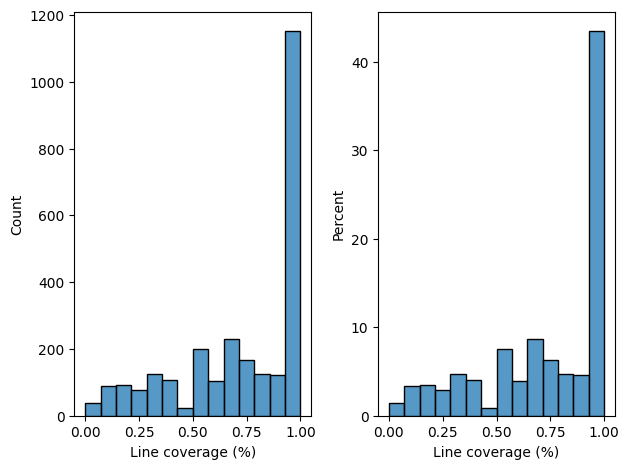

In [11]:
# from matplotlib import ticker
fig, ax = plt.subplots(1, 2)
sns.histplot(df, x="line_coverage", stat="count", ax=ax[0])
sns.histplot(df, x="line_coverage", stat="percent", ax=ax[1])
plt.tight_layout()
# ax = plt.gca()
# # max_y = 0.8
# # ax.set_ylim([0, int(len(df)*max_y)])  # https://stackoverflow.com/a/25421861
# ax2 = ax.twinx()  # https://stackoverflow.com/a/35073179
# ax2.set_ylim(*ax.get_ylim())  # https://stackoverflow.com/a/15534984
# plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(df)))  # https://malithjayaweera.com/2018/09/add-matplotlib-percentage-ticks-histogram/
# ax2.yaxis.set_ticks(np.arange(0, len(df)+len(df)/20, len(df)/20))  # https://stackoverflow.com/a/12608937
# ax.set_ylabel("Count")
# ax2.set_ylabel("Percentage")
ax[0].set_xlabel("Line coverage (%)")
ax[1].set_xlabel("Line coverage (%)")

Text(0.5, 0, 'Unique function-level inputs')

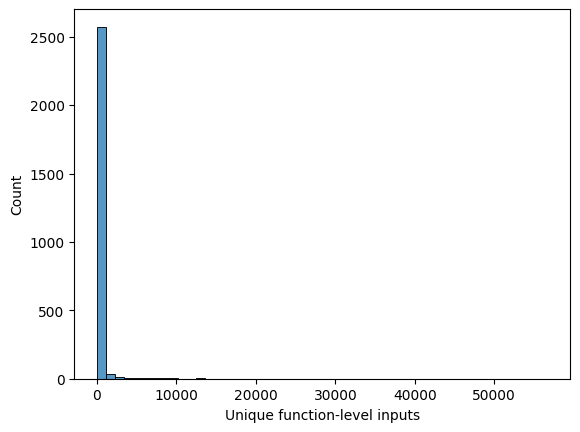

In [12]:
sns.histplot(df, x="num_unique_inputs", bins=50)
plt.xlabel("Unique function-level inputs")

In [13]:
print(df.groupby(["project"]).ngroups, "projects")
print("average", round(df.groupby("project")["method"].count().mean(), 1), "methods per project")
print("median", round(df.groupby("project")["method"].count().median(), 1), "methods per project")
print(len(df), "unique methods")
print(str(round((df["num_unique_inputs"] == 1).mean() * 100, 2)) + "%", "have 1 unique input")
print("Frequencies of 1-5 unique inputs")
print(df["num_unique_inputs"].value_counts(normalize=True).sort_index().head(5).apply(lambda f: f"{round(100*f, 2)}%"))

print("Overall stats:")
print(pd.DataFrame((df["line_coverage"].describe(), df["num_unique_inputs"].describe())).to_markdown())

print("Broken down by project (MEAN):")
mean_by_project = df.dropna().groupby("project")[["line_coverage", "num_unique_inputs"]].mean()
t = df.dropna().groupby("project")[["line_coverage", "num_unique_inputs"]].agg(["mean", "count"])
print(t.to_csv())
print("Broken down by project (MEDIAN):")
print(df.dropna().groupby("project")[["line_coverage", "num_unique_inputs"]].median().to_markdown())

77 projects
average 34.4 methods per project
median 19.0 methods per project
2649 unique methods
37.3% have 1 unique input
Frequencies of 1-5 unique inputs
1     37.3%
2    19.03%
3     4.57%
4     3.47%
5     1.93%
Name: num_unique_inputs, dtype: object
Overall stats:
|                   |   count |       mean |        std |   min |   25% |      50% |   75% |   max |
|:------------------|--------:|-----------:|-----------:|------:|------:|---------:|------:|------:|
| line_coverage     |    2649 |   0.733376 |    0.29549 |     0 |   0.5 | 0.833333 |     1 |     1 |
| num_unique_inputs |    2649 | 185.017    | 1519.79    |     1 |   1   | 2        |    14 | 56748 |
Broken down by project (MEAN):
,line_coverage,line_coverage,num_unique_inputs,num_unique_inputs
,mean,count,mean,count
project,,,,
angus-mail,0.8202835811531464,9,154.22222222222223,9
apache-commons,0.7858398908878024,314,78.35350318471338,314
apache-commons-bcel,0.6489832960457196,19,17.105263157894736,19
apache-commons-bea

Text(0.5, 0, 'Mean function-level line coverage by project')

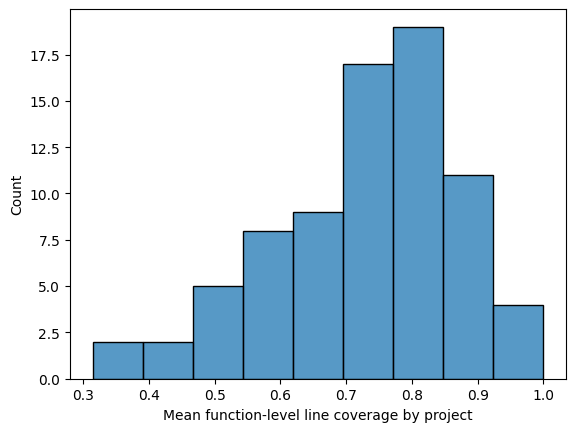

In [14]:
sns.histplot(mean_by_project, x="line_coverage")
plt.xlabel("Mean function-level line coverage by project")

Text(0.5, 0, 'Mean unique function-level inputs by project')

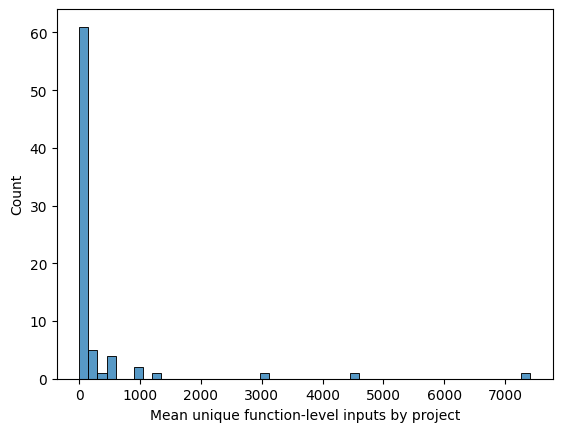

In [15]:
sns.histplot(mean_by_project, x="num_unique_inputs", bins=50)
plt.xlabel("Mean unique function-level inputs by project")

<AxesSubplot: xlabel='line_coverage', ylabel='Count'>

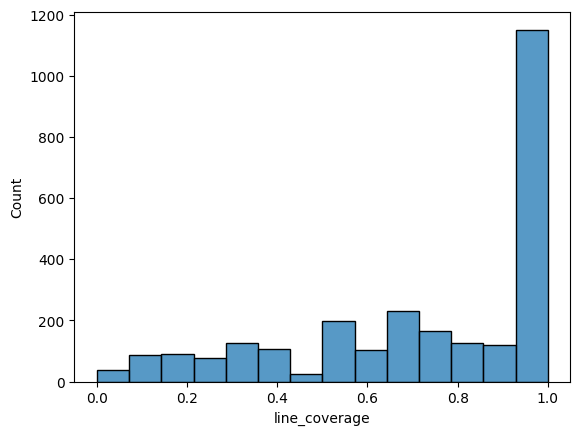

In [16]:
sns.histplot(df, x="line_coverage")

Text(0.5, 0, '# methods')

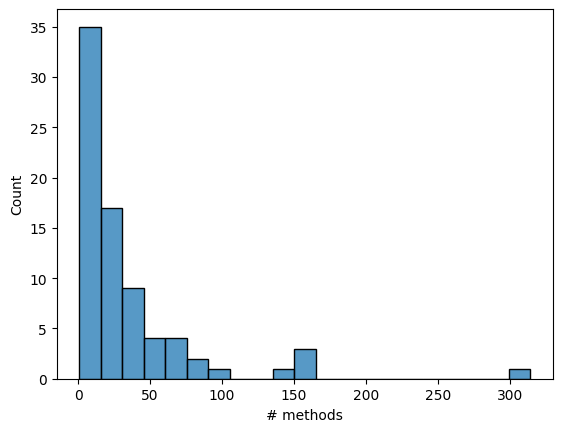

In [17]:
sns.histplot(df.groupby("project")["method"].count())
plt.xlabel("# methods")

In [19]:
data = []
with open("dataset_stats.py/fuzzed_input_counts.txt") as f:
    for line in f:
        project, fuzzer, count = line.split()
        fuzzer = fuzzer[len("address-x86_64-"):]
        data.append({
            "project": project,
            "fuzzer": fuzzer,
            "count": int(count),
        })
fdf = pd.DataFrame(data)
fdf

,project,fuzzer,count
0,angus-mail,ASCIIUtilityFuzzer,54
1,angus-mail,BASE64EncoderStreamFuzzer,104
2,antlr4-java,GrammarFuzzer,0
3,apache-commons,CompressSevenZFuzzer,501
4,apache-commons,CompressTarFuzzer,7878
...,...,...,...
206,tomcat,WsPingPongFuzzer,1420
207,woodstox,XmlFuzzer,814
208,xmlpull,PullParserFactoryFuzzer,15
209,xstream,XmlFuzzer,11400


Text(0, 0.5, '# fuzzer targets')

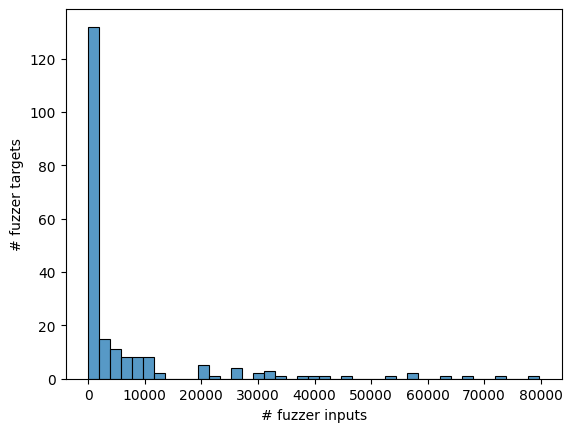

In [20]:
sns.histplot(fdf, x="count")
# plt.xscale("log")
plt.xlabel("# fuzzer inputs")
plt.ylabel("# fuzzer targets")

Text(0, 0.5, '# projects')

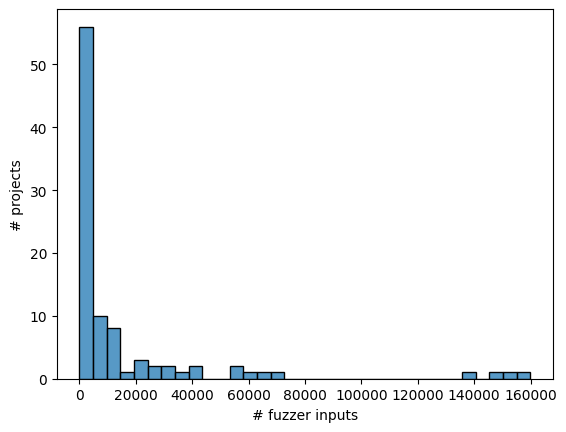

In [21]:
sns.histplot(fdf.groupby("project")["count"].sum())
# plt.xscale("log")
plt.xlabel("# fuzzer inputs")
plt.ylabel("# projects")

In [22]:
mdf = df.dropna()
mean_stats = mdf.groupby("project")[["line_coverage", "num_unique_inputs"]].mean()
counts = mdf.groupby("project")["line_coverage"].count().rename("function_count")
project_fuzzedinput_counts = fdf.groupby("project")["count"].sum().rename("input_count")
rdf = mean_stats.join(counts).join(project_fuzzedinput_counts).reset_index()
# rdf = pd.melt(rdf, id_vars="project", var_name="stat", value_name="value")
# rdf = rdf.sort_values(["project", "stat"])
# rdf["value"] = rdf["value"].astype(float)
# sns.barplot(x='project', y='value', hue='stat', data=rdf)
rdf.to_clipboard()
rdf

,project,line_coverage,num_unique_inputs,function_count,input_count
0,angus-mail,0.820284,154.222222,9,158
1,apache-commons,0.785840,78.353503,314,18078
2,apache-commons-bcel,0.648983,17.105263,19,351
3,apache-commons-beanutils,0.757871,1278.785714,14,7145
4,apache-commons-cli,0.847351,165.951220,41,1615
...,...,...,...,...,...
72,tomcat,0.683794,102.006667,150,68601
73,woodstox,0.575269,1.117647,17,814
74,xmlpull,0.666358,10.666667,6,15
75,xstream,0.745544,8.196078,51,11400


Text(0, 0.5, '# unique function-level inputs')

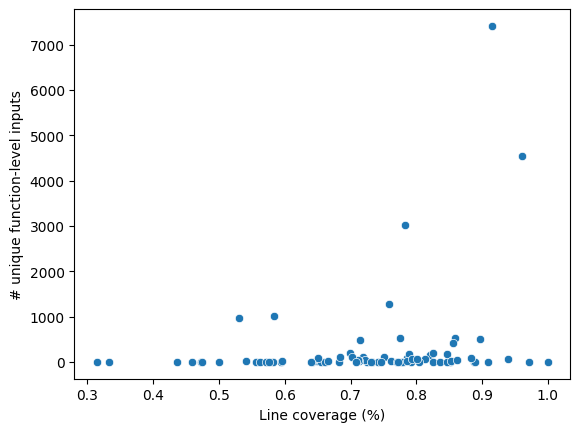

In [23]:
sns.scatterplot(data=rdf, x="line_coverage", y="num_unique_inputs")
plt.xlabel("Line coverage (%)")
plt.ylabel("# unique function-level inputs")

Text(0, 0.5, '# fuzzer inputs')

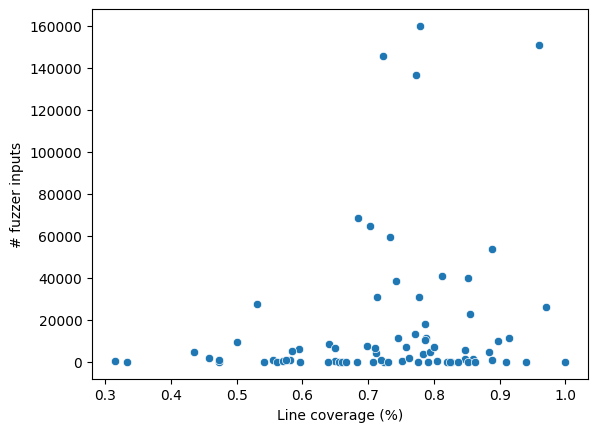

In [24]:
sns.scatterplot(data=rdf, x="line_coverage", y="input_count")
plt.xlabel("Line coverage (%)")
plt.ylabel("# fuzzer inputs")

Text(0, 0.5, '# functions')

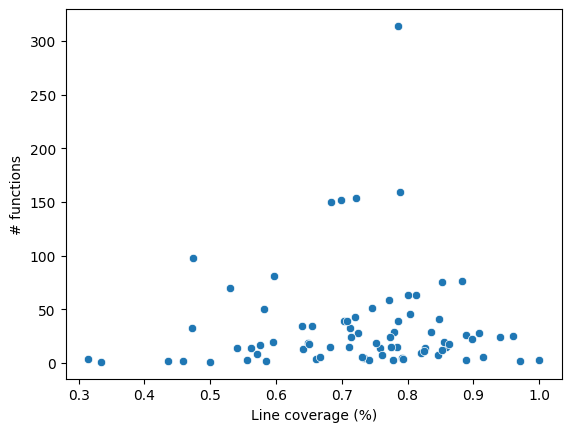

In [25]:
sns.scatterplot(data=rdf, x="line_coverage", y="function_count")
plt.xlabel("Line coverage (%)")
plt.ylabel("# functions")

Text(0, 0.5, '# unique function-level inputs')

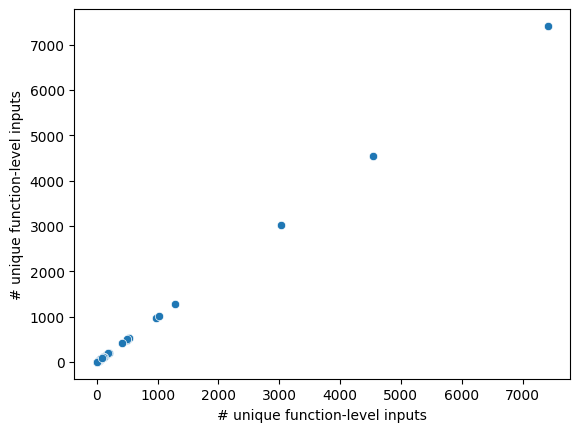

In [26]:
sns.scatterplot(data=rdf, x="num_unique_inputs", y="num_unique_inputs")
plt.xlabel("# unique function-level inputs")
plt.ylabel("# unique function-level inputs")

Text(0, 0.5, '# fuzzer inputs')

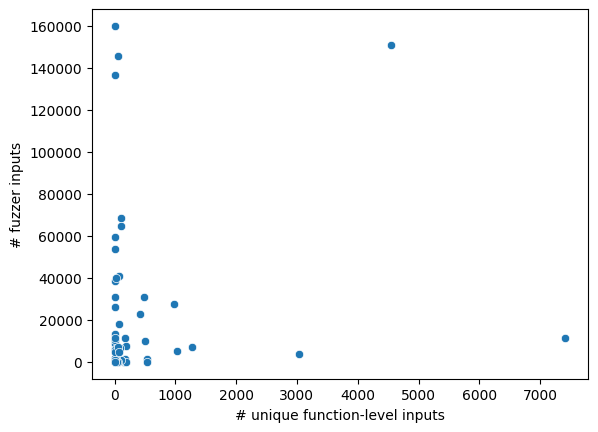

In [27]:
sns.scatterplot(data=rdf, x="num_unique_inputs", y="input_count")
plt.xlabel("# unique function-level inputs")
plt.ylabel("# fuzzer inputs")

Text(0, 0.5, '# functions')

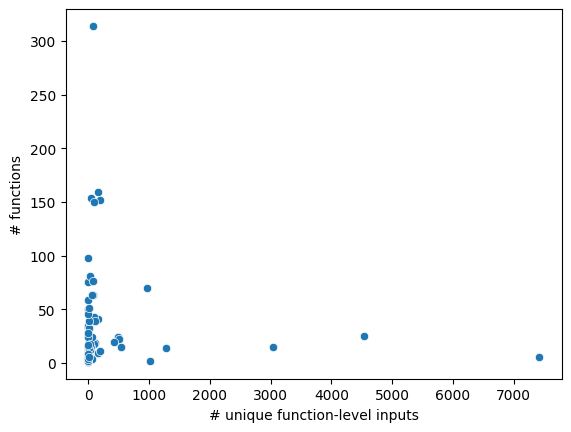

In [28]:
sns.scatterplot(data=rdf, x="num_unique_inputs", y="function_count")
plt.xlabel("# unique function-level inputs")
plt.ylabel("# functions")